In [ ]:
!pip install split-folders

#Midterm Project by Paul Tuccinardi

##Lung cancer CNN detection

#Data Preparation

Data: This data has 3 folders one for benign, adnocarcinoma and squamous cell carcinoma which each contain 5,000 images. Due to the large data size, the data was uploaded to my google drive to save time.

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import os
import shutil
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
adenocarcinoma_path='/content/drive/MyDrive/adenocarcinoma'
benign_path='/content/drive/MyDrive/benign'
squamous_cell_carcinoma_path='/content/drive/MyDrive/squamous_cell_carcinoma'

In [ ]:
def split_data(source_dir, train_dir, val_dir, test_dir, val_size=0.2, test_size=0.1):
    for label in ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']:
        files = os.listdir(os.path.join(source_dir, label))
        train_files, val_test_files = train_test_split(files, test_size=val_size + test_size)
        val_files, test_files = train_test_split(val_test_files, test_size=test_size / (val_size + test_size))

        for file in train_files:
            shutil.copy(os.path.join(source_dir, label, file), os.path.join(train_dir, label, file))
        for file in val_files:
            shutil.copy(os.path.join(source_dir, label, file), os.path.join(val_dir, label, file))
        for file in test_files:
            shutil.copy(os.path.join(source_dir, label, file), os.path.join(test_dir, label, file))

In [ ]:
# Create a main input directory if it doesn't exist
main_input_dir = '/content/drive/MyDrive/all_images'  # Or any suitable path
os.makedirs(main_input_dir, exist_ok=True)

# Create subdirectories for each class within the main input directory
class_dirs = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']
for class_dir in class_dirs:
    os.makedirs(os.path.join(main_input_dir, class_dir), exist_ok=True)

# Move images into their respective class subdirectories
# Note: Replace '*.jpg' with the actual file extension of your images if it's different
for filename in os.listdir(adenocarcinoma_path):
    if filename.endswith('.jpg'):
        shutil.move(os.path.join(adenocarcinoma_path, filename),
                    os.path.join(main_input_dir, 'adenocarcinoma', filename))

for filename in os.listdir(benign_path):
    if filename.endswith('.jpg'):
        shutil.move(os.path.join(benign_path, filename),
                    os.path.join(main_input_dir, 'benign', filename))

for filename in os.listdir(squamous_cell_carcinoma_path):
    if filename.endswith('.jpg'):
        shutil.move(os.path.join(squamous_cell_carcinoma_path, filename),
                    os.path.join(main_input_dir, 'squamous_cell_carcinoma', filename))

# Now use the main_input_dir for splitting
output_dir = '/content/drive/MyDrive/split_data'
splitfolders.ratio(main_input_dir, output=output_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)


Copying files: 15050 files [11:48, 21.25 files/s]


#Creating the CNN Model

In [ ]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_dir = '/content/drive/MyDrive/split_data/train'
val_dir = '/content/drive/MyDrive/split_data/val'
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = '/content/drive/MyDrive/split_data/test'

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Assuming you have multiple classes
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Assuming you have multiple classes
)

# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))  # 3 output classes (adenocarcinoma, benign, squamous_cell_carcinoma)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_data,
    epochs=10,  # Adjust as needed
    validation_data=val_data
)


Found 1505 images belonging to 3 classes.
Found 12040 images belonging to 3 classes.
Found 1505 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


377/377 ━━━━━━━━━━━━━━━━━━━━ 170s 311ms/step - accuracy: 0.7060 - loss: 0.6945 - val_accuracy: 0.9023 - val_loss: 0.2469
Epoch 2/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 112s 293ms/step - accuracy: 0.8927 - loss: 0.2614 - val_accuracy: 0.9063 - val_loss: 0.1976
Epoch 3/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 130s 262ms/step - accuracy: 0.9232 - loss: 0.1913 - val_accuracy: 0.9455 - val_loss: 0.1449
Epoch 4/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 151s 287ms/step - accuracy: 0.9506 - loss: 0.1326 - val_accuracy: 0.9561 - val_loss: 0.1204
Epoch 5/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 129s 254ms/step - accuracy: 0.9584 - loss: 0.1125 - val_accuracy: 0.9508 - val_loss: 0.1139
Epoch 6/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 140s 248ms/step - accuracy: 0.9788 - loss: 0.0652 - val_accuracy: 0.9535 - val_loss: 0.1241
Epoch 7/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 143s 250ms/step - accuracy: 0.9822 - loss: 0.0497 - val_accuracy: 0.9681 - val_loss: 0.0945
Epoch 8/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 95s 249ms/step - accuracy: 0.9887 - loss: 0.030

#Testing model

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the validation set
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the validation set
y_true = test_data.classes

# Create the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step
Confusion Matrix:
[[172 167 165]
 [181 165 154]
 [191 164 146]]


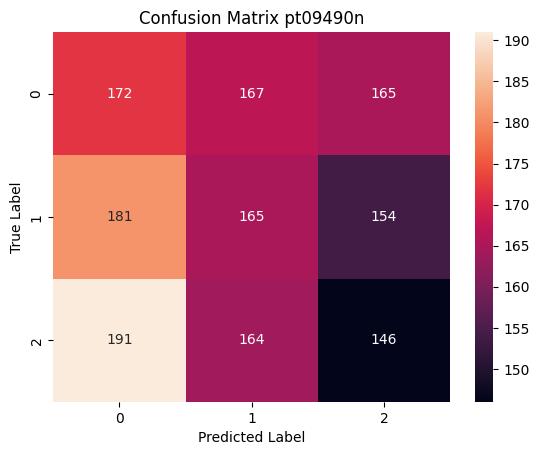

In [ ]:
import seaborn as sns
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.title('Confusion Matrix pt09490n')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have already calculated the confusion matrix (confusion_mtx)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_true, y_pred_classes, average='weighted')  # Use 'weighted' for multi-class
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_true, y_pred_classes, average='weighted')  # Use 'weighted' for multi-class
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_true, y_pred_classes, average='weighted')  # Use 'weighted' for multi-class
print(f"F1-score: {f1}")

Accuracy: 0.3209302325581395
Precision: 0.3209214698632641
Recall: 0.3209302325581395
F1-score: 0.3206237600631537
